In [1]:
import ROOT as rt
import numpy as np
import array
import plotLib.tdrstyle as tdrstyle
import plotLib.CMS_lumi as CMS_lumi
import re

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

tdrstyle.setTDRStyle()
rt.gStyle.SetOptStat(0)

Welcome to JupyROOT 6.18/02


# First scan the baseline training

In [2]:
#indir = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output_fullbkg_cutBothPho/'
#indir = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output_minimalCut_wPt_decay20_highCtau/'
indir = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output_baselineCut_noTrigger/'
data_name = indir+'/DelayedPhoton_DoubleEG_2016All_GoodLumi.root'
#signal_name = indir+'/DelayedPhoton_GMSB_L250TeV_Ctau200cm_13TeV-pythia8.root'
signal_name = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/GMSB_L-250TeV_Ctau-200cm_13TeV-pythia8.root'

# Boundary 
#MET_boundary = 250.0
#time_boundary = 0.0
MET_boundary = 100.0
time_boundary = 1.5

lumi_2016 = 35922.0
lumi_2017 = 41530.0
lumi = lumi_2016

event_cut = 'n_Jets > 2 && n_Photons == 2'
             
trigger_cut = ' && HLTDecision[81] == 1'

inclusive_trigger_cut = ' && (HLTDecision[80] == 1 ||\
                              HLTDecision[81] == 1 ||\
                              HLTDecision[82] == 1 ||\
                              HLTDecision[84] == 1 ||\
                              HLTDecision[85] == 1 ||\
                              HLTDecision[86] == 1 ||\
                              HLTDecision[87] == 1 ||\
                              HLTDecision[101] == 1 ||\
                              HLTDecision[102] == 1 ||\
                              HLTDecision[103] == 1 ||\
                              HLTDecision[104] == 1 ||\
                              HLTDecision[112] == 1 ||\
                              HLTDecision[116] == 1 ||\
                              HLTDecision[220] == 1 ||\
                              HLTDecision[221] == 1\
                              )'

MET_cut = " && Flag_HBHENoiseFilter == 1 \
            &&Flag_HBHEIsoNoiseFilter ==1 \
            && Flag_goodVertices == 1 \
            && Flag_eeBadScFilter == 1 \
            && Flag_EcalDeadCellTriggerPrimitiveFilter == 1 \
            && Flag_CSCTightHaloFilter == 1  \
            && Flag_badMuonFilter == 1 \
            && Flag_badGlobalMuonFilter == 0 \
            && Flag_duplicateMuonFilter ==0"

pho_cut = '&& pho1Pt > 70 && abs(pho1Eta)<1.4442 \
            && pho1passEleVeto \
            && pho1R9 > 0.85 && abs(pho1SigmaIetaIeta) < 0.024 '

# && abs(pho1ecalPFClusterIso) < 7.5 \
#             && abs(pho1hcalPFClusterIso) < 5.0 \
#             && abs(pho1trkSumPtHollowConeDR03) < 7.5 
# && abs(pho1HoverE) < 0.08 \
#             \

pho_cutbasedID = '&& pho1Pt > 70 \
                && pho1R9 > 0.9 \
                && abs(pho1Eta)<1.4442 \
                && pho1passEleVeto \
                && pho1Sminor<0.4 \
                && pho1passSigmaIetaIetaTight \
                && pho1passHoverETight \
                && pho1passSmajorTight \
                && pho1passIsoTight_comboIso'

pho2_cut = '&& pho2SigmaIetaIeta < 0.03 \
            && pho2HoverE < 0.1 \
            && pho2ecalPFClusterIso < 30.0 \
            && pho2sumNeutralHadronEt < 30.0 \
            && pho2trkSumPtHollowConeDR03 < 30.0'

baseline_cut = event_cut + trigger_cut + pho_cut + MET_cut + pho2_cut
baseline_inclusive_cut = event_cut + inclusive_trigger_cut + pho_cut + MET_cut + pho2_cut
cut_based_id = event_cut + trigger_cut + pho_cutbasedID + MET_cut + pho2_cut
cut_based_id_inclusive = event_cut + inclusive_trigger_cut + pho_cutbasedID + MET_cut + pho2_cut


def getXS(sample):
    with open("/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/data/all_bkg_back.list", "r") as xsfile:
        allxs = xsfile.readlines()
        for xs in allxs:
            if xs.split(' ')[0] in sample:
                return xs.split(' ')[-1].replace('\n','')
    print("[WARNING] {} cross section not found".format(sample))
    return 0

def extract_num(string):
    sample_num = list(map(int, re.findall(r'\d+', string.split('/')[-1])))
    if len(sample_num) > 1:
        sample_lambda, sample_ctau = sample_num[0], sample_num[1]
        if sample_ctau == 0:
            if "0_001cm" in string:
                sample_ctau = 0.001
            elif "0_01cm" in string:
                sample_ctau = 0.01
            elif "0_1cm" in string:
                sample_ctau = 0.1

        return sample_lambda, sample_ctau
    else:
        print("Can't extract number from {}".format(string))
        return 0, 0

def getSignalXS(sample):
    """Get cross section x BR for signal MC"""
    sample_lambda, sample_ctau = extract_num(sample)

    dat_file = "/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/data/XsecBR.dat"
    with open(dat_file, "r") as xsfile:
        allxs = xsfile.readlines()
        for xs in allxs[1:]:
            this_lambda, this_ctau = extract_num(xs)
            if sample_lambda == this_lambda and sample_ctau == this_ctau:
                return float(xs.split(' ')[4])
    print("[WARNING] {} cross section not found in {}".format(sample, dat_file))
    return 0

### Get an example of time and MET templates

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


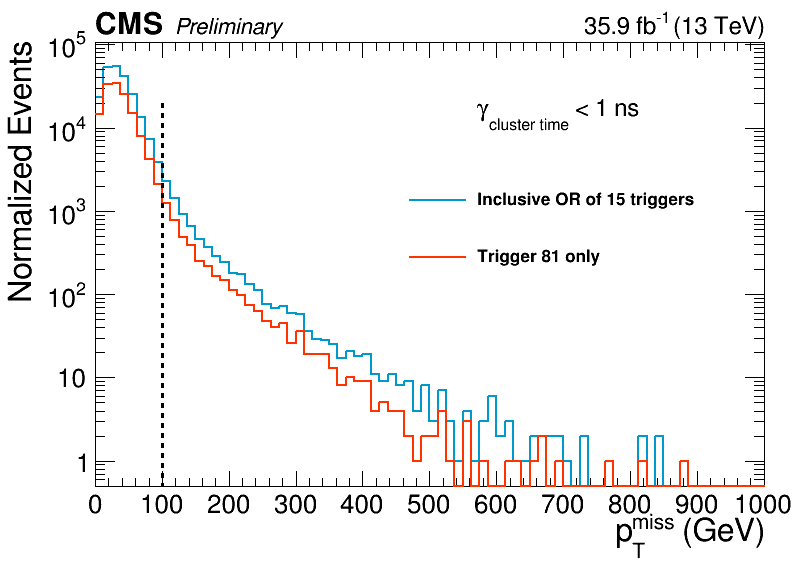

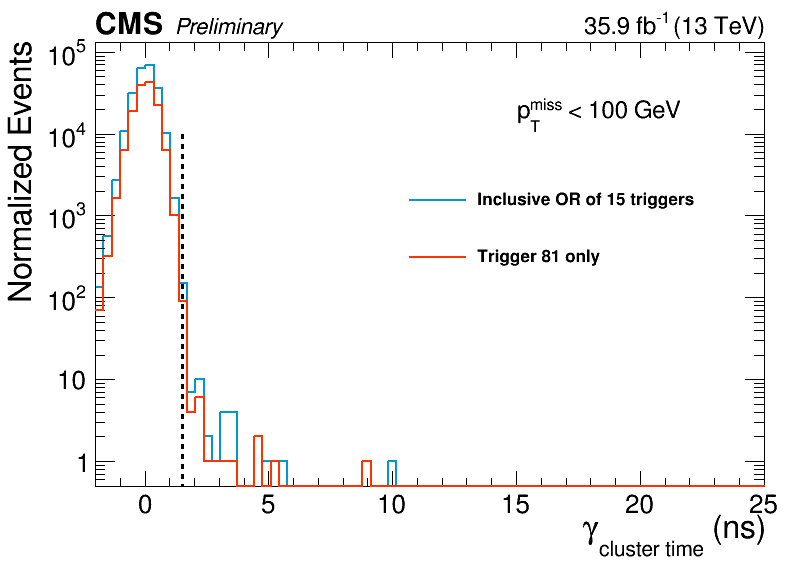

In [3]:
data_file = rt.TFile.Open(data_name, "READ")
signal_file = rt.TFile.Open(signal_name, "READ")
data_tree = data_file.Get("DelayedPhoton")
signal_tree = signal_file.Get("DelayedPhoton")
tmp_sw = signal_file.Get("SumWeights")
sumWeights = tmp_sw.Integral()

data_MET_old = rt.TH1F("data_MET_old", "; p_{T}^{miss} (GeV)", 80, 0, 1000)
data_MET_inclusive = rt.TH1F("data_MET_inclusive", "; p_{T}^{miss} (GeV)", 80, 0, 1000)

data_time_old = rt.TH1F("data_time_old", "; #gamma_{cluster time} (ns)", 80, -2, 25)
data_time_inclusive = rt.TH1F("data_time_inclusive", "; #gamma_{cluster time} (ns)", 80, -2, 25)


data_tree.Draw("t1MET >> data_MET_old", baseline_cut+"&& (pho1ClusterTime_SmearToData) < 1.0")
data_MET_old.SetDirectory(0)
data_tree.Draw("pho1ClusterTime_SmearToData >> data_time_old", baseline_cut+"&& t1MET < 100")
data_time_old.SetDirectory(0)


data_tree.Draw("t1MET >> data_MET_inclusive", baseline_inclusive_cut+"&& (pho1ClusterTime_SmearToData) < 1.0")
data_MET_inclusive.SetDirectory(0)
data_tree.Draw("pho1ClusterTime_SmearToData >> data_time_inclusive", baseline_inclusive_cut+"&& t1MET < 100")
data_time_inclusive.SetDirectory(0)

CMS_lumi.extraText = "Preliminary"
CMS_lumi.lumi_sqrtS = "35.9 fb^{-1} (13 TeV)"
iPos = 0
CMS_lumi.relPosX = 0.12

H_ref = 600;
W_ref = 800;
W = W_ref
H  = H_ref
iPeriod = 0

# references for T, B, L, R
T = 0.1*H_ref
B = 0.2*H_ref
L = 0.12*W_ref
R = 0.04*W_ref

### MET template
c1 = rt.TCanvas("c1", "", 50, 50, W, H)
c1.cd()
c1.SetLeftMargin(L/W)
c1.SetRightMargin(R/W)
c1.SetTopMargin(T/W)
c1.SetBottomMargin(B/W)
#data_MET.SetFillColor(rt.kAzure+8)
data_MET_inclusive.SetLineColor(rt.kAzure+9)
data_MET_inclusive.SetLineWidth(2)
data_MET_inclusive.GetYaxis().SetTitle("Normalized Events")
data_MET_inclusive.GetYaxis().SetTitleOffset(1.)
#data_MET_inclusive.Scale(1./data_MET_inclusive.Integral())
data_MET_inclusive.Draw("hist")
data_MET_old.SetLineColor(rt.kOrange+10)
data_MET_old.SetLineWidth(2)
#data_MET_old.Scale(1./data_MET_old.Integral())
data_MET_old.Draw("hist same")
rt.gPad.SetLogy()
c1.Draw()
CMS_lumi.CMS_lumi(c1, iPeriod, iPos)
c1.cd()
line1 = rt.TLine(MET_boundary, 0, MET_boundary, 2e4)
line1.SetLineStyle(7)
line1.SetLineWidth(3)
line1.Draw()

latex = rt.TLatex()
latex.SetTextFont(42)
latex.SetTextAngle(0)
latex.SetTextColor(rt.kBlack)
latex.SetTextSize(0.045)
latex.SetTextAlign(12)
latex.DrawLatexNDC(0.6, 0.8,"#gamma_{cluster time} < 1 ns")


leg1 = rt.TLegend(0.5,0.5,0.9,0.7)
leg1.SetBorderSize(0)
leg1.AddEntry(data_MET_inclusive, "Inclusive OR of 15 triggers", "fl")
leg1.AddEntry(data_MET_old, "Trigger 81 only", "fl")
leg1.Draw()



### Time template
c2 = rt.TCanvas("c2", "", 50, 50, W, H)
c2.cd()
c2.SetLeftMargin(L/W)
c2.SetRightMargin(R/W)
c2.SetTopMargin(T/W)
c2.SetBottomMargin(B/W)
#data_time.SetFillColor(rt.kAzure+8)
data_time_inclusive.SetLineColor(rt.kAzure+9)
data_time_inclusive.SetLineWidth(2)
data_time_inclusive.GetYaxis().SetTitle("Normalized Events")
data_time_inclusive.GetYaxis().SetTitleOffset(1.)
#data_time_inclusive.Scale(1./data_time_inclusive.Integral())
data_time_inclusive.Draw("hist")
data_time_old.SetLineColor(rt.kOrange+10)
data_time_old.SetLineWidth(2)
#data_time_old.Scale(1./data_time_old.Integral())
data_time_old.Draw("hist same")
rt.gPad.SetLogy()
c2.Draw()
CMS_lumi.CMS_lumi(c2, iPeriod, iPos)
c2.cd()
line2 = rt.TLine(time_boundary, 0, time_boundary, 1e4)
line2.SetLineStyle(7)
line2.SetLineWidth(3)
line2.Draw()


latex = rt.TLatex()
latex.SetTextFont(42)
latex.SetTextAngle(0)
latex.SetTextColor(rt.kBlack)
latex.SetTextSize(0.045)
latex.SetTextAlign(12)
latex.DrawLatexNDC(0.65, 0.8,"p_{T}^{miss} < 100 GeV")
#latex.DrawLatexNDC(0.63, 0.65,"N_{DA} = #frac{#gamma_{cluster time} > 1.5}{#gamma_{cluster time} < 1.5}")


leg2 = rt.TLegend(0.5,0.5,0.9,0.7)
leg2.SetBorderSize(0)
leg2.AddEntry(data_time_inclusive, "Inclusive OR of 15 triggers", "fl")
leg2.AddEntry(data_time_old, "Trigger 81 only", "fl")
leg2.Draw()

In [56]:
### Test for independence
from prettytable import PrettyTable
from scipy import stats

def chsq(d, f):
    # http://cousins.web.cern.ch/cousins/ongoodness6march2016.pdf
    return 2 * (f - d + d * np.log(d/f))

def chisquare_test(A, B, C, D):
    N = A + B + C + D
    rowAD = A + D
    rowBC = B + C
    colAB = A + B
    colCD = C + D
    A_exp = rowAD * colAB / N
    B_exp = rowBC * colAB / N
    C_exp = rowBC * colCD / N
    D_exp = rowAD * colCD / N
    tb = PrettyTable(["","A","B","C","D"])
    tb.add_row(["Obs","{:.2f}".format(A),"{:.2f}".format(B),"{:.2f}".format(C),"{:.2f}".format(D)])
    tb.add_row(["Exp","{:.2f}".format(A_exp),"{:.2f}".format(B_exp),"{:.2f}".format(C_exp),"{:.2f}".format(D_exp)])
    print(tb)
    test_statistics = chsq(A, A_exp) + chsq(B, B_exp) + chsq(C, C_exp) + chsq(D, D_exp)
    pval = 1 - stats.chi2.cdf(test_statistics, 1)
    print("p-value = {:.4f}".format(pval))
    return pval
#     ### Use built-in library
#     doublecheck = stats.chisquare([A,B,C,D],[A_exp,B_exp,C_exp,D_exp],1)
#     print(doublecheck)
    
chisquare_test(3.42968, 26.1895, 10.6087, 1.90507)


+-----+------+-------+-------+------+
|     |  A   |   B   |   C   |  D   |
+-----+------+-------+-------+------+
| Obs | 3.43 | 26.19 | 10.61 | 1.91 |
| Exp | 3.75 | 25.87 | 10.93 | 1.58 |
+-----+------+-------+-------+------+
p-value = 0.7488


0.7487591106473057

### Using DNN score 

In [4]:
def getTransferFactor(DNN_threshold, baseline_cut):
    # Return N_BA and N_DA
    # Get the transfer factor
    cut_timeCR = baseline_cut + "&& pho1ClusterTime_SmearToData < 1.0 \
                                 && pho1DNN >= {DNN_threshold}".format(DNN_threshold=DNN_threshold)
    cut_below = cut_timeCR + "&& t1MET < {MET_boundary}".format(MET_boundary=MET_boundary)
    cut_above = cut_timeCR + "&& t1MET >= {MET_boundary}".format(MET_boundary=MET_boundary)
    MET_below = data_tree.GetEntries(cut_below)
    MET_above = data_tree.GetEntries(cut_above)
    if MET_above == 0 or MET_below == 0: return 0, 0
    
    N_BA = float(MET_above/MET_below)

    cut_METCR = baseline_cut + "&& t1MET < 100 \
                                && pho1DNN >= {DNN_threshold}".format(DNN_threshold=DNN_threshold)
    cut_below = cut_METCR + "&& pho1ClusterTime_SmearToData < {time_boundary}".format(time_boundary=time_boundary)
    cut_above = cut_METCR + "&& pho1ClusterTime_SmearToData >= {time_boundary}".format(time_boundary=time_boundary)
    time_below = data_tree.GetEntries(cut_below)
    time_above = data_tree.GetEntries(cut_above)
    if time_above == 0 or time_below == 0: return 0, 0
    N_DA = float(time_above/time_below)
    
    return N_BA, N_DA


def getBackgroundPrediction(DNN_threshold, N_BA, N_DA, baseline_cut):
    # Get the bin prediction
    cut_binA = baseline_cut 
    cut_binA += " && pho1ClusterTime_SmearToData >= -2.0"
    cut_binA += " && pho1ClusterTime_SmearToData <= {}".format(time_boundary)
    cut_binA += " && t1MET <= {}".format(MET_boundary)
    cut_binA += " && pho1DNN >= {}".format(DNN_threshold)
    binA = data_tree.GetEntries(cut_binA)
    
    binB_pred = binA * N_BA
    binD_pred = binA * N_DA
    binC_pred = binA * N_DA * N_BA
    return binA, binB_pred, binC_pred, binD_pred

def getSignalYield(DNN_threshold, baseline_cut):
    # Return the signal histogram
    this_lambda, this_ctau = extract_num(signal_name)
    xs = getSignalXS(signal_name)
    xsecOverSumweights = float(xs)/sumWeights
    
    bin_MET = array.array('d', [0, MET_boundary, 9000])
    bin_time = array.array('d', [-2, time_boundary, 25])
    
    signal_hist = rt.TH2F("signal_hist", "; Time; MET", 2, bin_time, 2, bin_MET)
    
    cut_sig = baseline_cut
    cut_sig += " && pho1DNN > {}".format(DNN_threshold)
    
    signal_tree.Draw("t1MET:pho1ClusterTime_SmearToData>>signal_hist", 
                     "({cut_sig})*(weight*pileupWeight*triggerEffSFWeight*photonEffSF* \
                     {lumi} * {xsecOverSumweights})".format(cut_sig=cut_sig,
                                                           lumi=lumi,
                                                           xsecOverSumweights=xsecOverSumweights))
    signal_hist.SetDirectory(0)
    return signal_hist

def significance(s, b):
    if b == 0: return 0
    x = 2 * ((s + b) * np.log(1 + float(s/b)) - s)
    return np.sqrt(x)

def getSignificance(DNN_threshold, baseline_cut):
    N_BA, N_DA = getTransferFactor(DNN_threshold, baseline_cut)

    binA, binB_pred, binC_pred, binD_pred = getBackgroundPrediction(DNN_threshold, N_BA, N_DA)

    signal_hist = getSignalYield(DNN_threshold, baseline_cut)
    
    binB_sig = signal_hist.GetBinContent(1, 2)
    binC_sig = signal_hist.GetBinContent(2, 2)
    binD_sig = signal_hist.GetBinContent(2, 1)

    ### Get the S/sqrt(B) of each bin

    significance_B = significance(binB_sig, binB_pred) #float(binB_sig/np.sqrt(binB_pred))
    significance_C = significance(binC_sig, binC_pred) #(float(binC_sig/np.sqrt(binC_pred))
    significance_D = significance(binD_sig, binD_pred) #float(binD_sig/np.sqrt(binD_pred))

    overall_sig = np.sqrt(np.power(significance_B, 2) 
                           + np.power(significance_C, 2)
                           + np.power(significance_D, 2))
    
    return overall_sig, significance_B, significance_C, significance_D 

In [5]:
def relabel(hist):
    hist.GetXaxis().SetNdivisions(-2)
    hist.GetXaxis().ChangeLabel(2,-1,-1,-1,-1,1, str(time_boundary))
    hist.GetYaxis().SetNdivisions(-2)
    hist.GetYaxis().ChangeLabel(2,-1,-1,-1,-1,1, str(MET_boundary))


N_BA = 0.043523088735329604, N_DA = 0.0003257611953264127


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


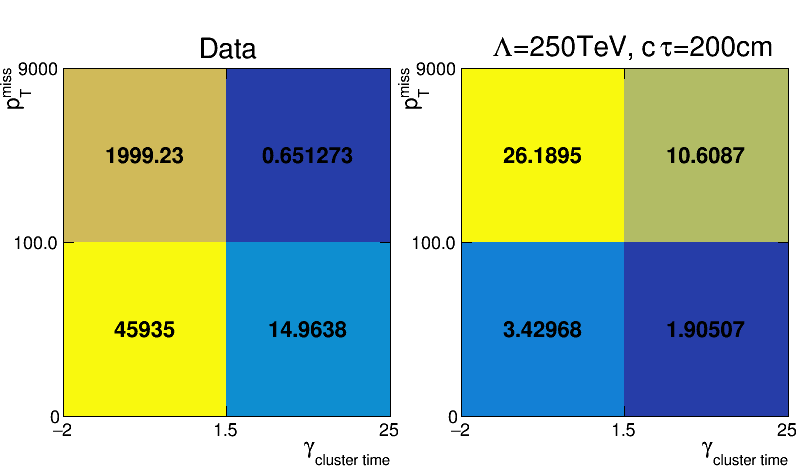

In [6]:
# DNN ABCD old trigger
DNN_threshold = 0.32

N_BA, N_DA = getTransferFactor(DNN_threshold, baseline_cut)
print("N_BA = {}, N_DA = {}".format(N_BA, N_DA))
binA, binB_pred, binC_pred, binD_pred = getBackgroundPrediction(DNN_threshold, N_BA, N_DA, baseline_cut)

signal_yield = getSignalYield(DNN_threshold, baseline_cut)


hist_data = rt.TH2F("hist_data", ";#gamma_{cluster time};p_{T}^{miss}", 2, -2, 25, 2, 0, 9000)
hist_data.SetBinContent(1, 1, binA)
hist_data.SetBinContent(1, 2, binB_pred)
hist_data.SetBinContent(2, 2, binC_pred)
hist_data.SetBinContent(2, 1, binD_pred)
hist_data.SetDirectory(0)

hist_signal = rt.TH2F("hist_signal", ";#gamma_{cluster time};p_{T}^{miss}", 2, -2, 25, 2, 0, 9000)
hist_signal.SetBinContent(1, 1, signal_yield.GetBinContent(1, 1))
hist_signal.SetBinContent(1, 2, signal_yield.GetBinContent(1, 2))
hist_signal.SetBinContent(2, 2, signal_yield.GetBinContent(2, 2))
hist_signal.SetBinContent(2, 1, signal_yield.GetBinContent(2, 1))
hist_signal.SetDirectory(0)

relabel(hist_data)
relabel(hist_signal)

c1 = rt.TCanvas("c1","",800,500)
c1.cd()
pad1 = rt.TPad("pad1", "", 0, 0, 0.5, 0.9)
pad1.Draw()
pad1.cd()
hist_data.SetMarkerSize(3)
hist_data.Draw("COL TEXT")
pad1.SetLogz()
c1.cd()
pad2 = rt.TPad("pad2", "", 0.5, 0, 1, 0.9)
pad2.Draw()
pad2.cd()
hist_signal.SetMarkerSize(3)
hist_signal.Draw("COL TEXT")
pad2.SetLogz()

# Draw title
c1.cd()
latex = rt.TLatex()
latex.SetTextFont(42)
latex.SetTextAngle(0)
latex.SetTextColor(rt.kBlack)
latex.SetTextSize(0.065)
latex.SetTextAlign(12)
latex.DrawLatexNDC(0.25, 0.90,"Data")
this_lambda, this_ctau = extract_num(signal_name)
signal_text = "#Lambda={}TeV, c#tau={}cm".format(this_lambda, this_ctau)
latex.DrawLatexNDC(0.62, 0.90, signal_text)

c1.Draw()


N_BA = 0.05141496564894963, N_DA = 0.0005280738812202191


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


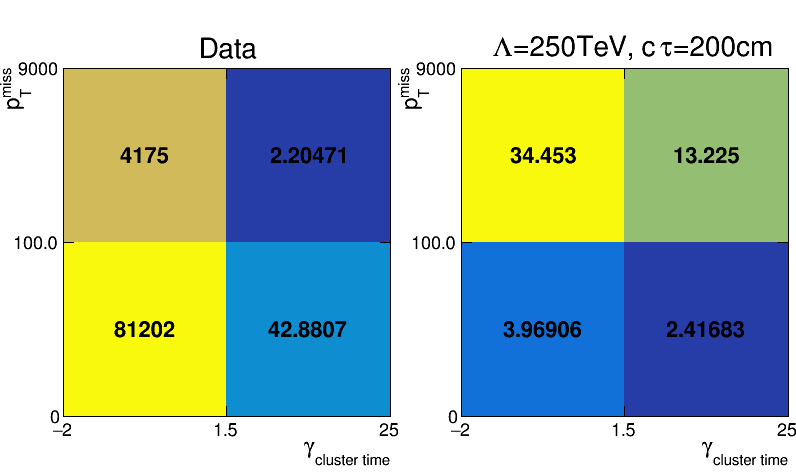

In [7]:
# DNN ABCD inclusive trigger
DNN_threshold = 0.32

N_BA, N_DA = getTransferFactor(DNN_threshold, baseline_inclusive_cut)
print("N_BA = {}, N_DA = {}".format(N_BA, N_DA))
binA, binB_pred, binC_pred, binD_pred = getBackgroundPrediction(DNN_threshold, N_BA, N_DA, baseline_inclusive_cut)

signal_yield = getSignalYield(DNN_threshold, baseline_inclusive_cut)


hist_data = rt.TH2F("hist_data", ";#gamma_{cluster time};p_{T}^{miss}", 2, -2, 25, 2, 0, 9000)
hist_data.SetBinContent(1, 1, binA)
hist_data.SetBinContent(1, 2, binB_pred)
hist_data.SetBinContent(2, 2, binC_pred)
hist_data.SetBinContent(2, 1, binD_pred)
hist_data.SetDirectory(0)

hist_signal = rt.TH2F("hist_signal", ";#gamma_{cluster time};p_{T}^{miss}", 2, -2, 25, 2, 0, 9000)
hist_signal.SetBinContent(1, 1, signal_yield.GetBinContent(1, 1))
hist_signal.SetBinContent(1, 2, signal_yield.GetBinContent(1, 2))
hist_signal.SetBinContent(2, 2, signal_yield.GetBinContent(2, 2))
hist_signal.SetBinContent(2, 1, signal_yield.GetBinContent(2, 1))
hist_signal.SetDirectory(0)

relabel(hist_data)
relabel(hist_signal)

c1 = rt.TCanvas("c1","",800,500)
c1.cd()
pad1 = rt.TPad("pad1", "", 0, 0, 0.5, 0.9)
pad1.Draw()
pad1.cd()
hist_data.SetMarkerSize(3)
hist_data.Draw("COL TEXT")
pad1.SetLogz()
c1.cd()
pad2 = rt.TPad("pad2", "", 0.5, 0, 1, 0.9)
pad2.Draw()
pad2.cd()
hist_signal.SetMarkerSize(3)
hist_signal.Draw("COL TEXT")
pad2.SetLogz()

# Draw title
c1.cd()
latex = rt.TLatex()
latex.SetTextFont(42)
latex.SetTextAngle(0)
latex.SetTextColor(rt.kBlack)
latex.SetTextSize(0.065)
latex.SetTextAlign(12)
latex.DrawLatexNDC(0.25, 0.90,"Data")
this_lambda, this_ctau = extract_num(signal_name)
signal_text = "#Lambda={}TeV, c#tau={}cm".format(this_lambda, this_ctau)
latex.DrawLatexNDC(0.62, 0.90, signal_text)

c1.Draw()


Totals signal: 28.814757347106934


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


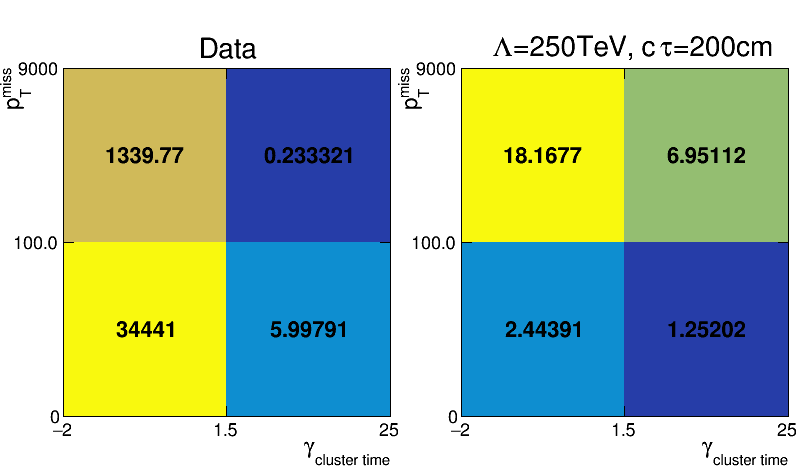

In [8]:
# Cut-based ID ABCD
DNN_threshold = -1

N_BA, N_DA = getTransferFactor(DNN_threshold, cut_based_id)
binA, binB_pred, binC_pred, binD_pred = getBackgroundPrediction(DNN_threshold, N_BA, N_DA, cut_based_id)

signal_yield = getSignalYield(DNN_threshold, cut_based_id)


hist_data = rt.TH2F("hist_data", ";#gamma_{cluster time};p_{T}^{miss}", 2, -2, 25, 2, 0, 9000)
hist_data.SetBinContent(1, 1, binA)
hist_data.SetBinContent(1, 2, binB_pred)
hist_data.SetBinContent(2, 2, binC_pred)
hist_data.SetBinContent(2, 1, binD_pred)
hist_data.SetDirectory(0)

hist_signal = rt.TH2F("hist_signal", ";#gamma_{cluster time};p_{T}^{miss}", 2, -2, 25, 2, 0, 9000)
hist_signal.SetBinContent(1, 1, signal_yield.GetBinContent(1, 1))
hist_signal.SetBinContent(1, 2, signal_yield.GetBinContent(1, 2))
hist_signal.SetBinContent(2, 2, signal_yield.GetBinContent(2, 2))
hist_signal.SetBinContent(2, 1, signal_yield.GetBinContent(2, 1))
hist_signal.SetDirectory(0)

relabel(hist_data)
relabel(hist_signal)

c1 = rt.TCanvas("c1","",800,500)
c1.cd()
pad1 = rt.TPad("pad1", "", 0, 0, 0.5, 0.9)
pad1.Draw()
pad1.cd()
hist_data.SetMarkerSize(3)
hist_data.Draw("COL TEXT")
pad1.SetLogz()
c1.cd()
pad2 = rt.TPad("pad2", "", 0.5, 0, 1, 0.9)
pad2.Draw()
pad2.cd()
hist_signal.SetMarkerSize(3)
hist_signal.Draw("COL TEXT")
pad2.SetLogz()

# Draw title
c1.cd()
latex = rt.TLatex()
latex.SetTextFont(42)
latex.SetTextAngle(0)
latex.SetTextColor(rt.kBlack)
latex.SetTextSize(0.065)
latex.SetTextAlign(12)
latex.DrawLatexNDC(0.25, 0.90,"Data")
this_lambda, this_ctau = extract_num(signal_name)
signal_text = "#Lambda={}TeV, c#tau={}cm".format(this_lambda, this_ctau)
latex.DrawLatexNDC(0.62, 0.90, signal_text)

c1.Draw()

print("Totals signal: {}".format(hist_signal.Integral()))

Totals signal: 34.35115170478821


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


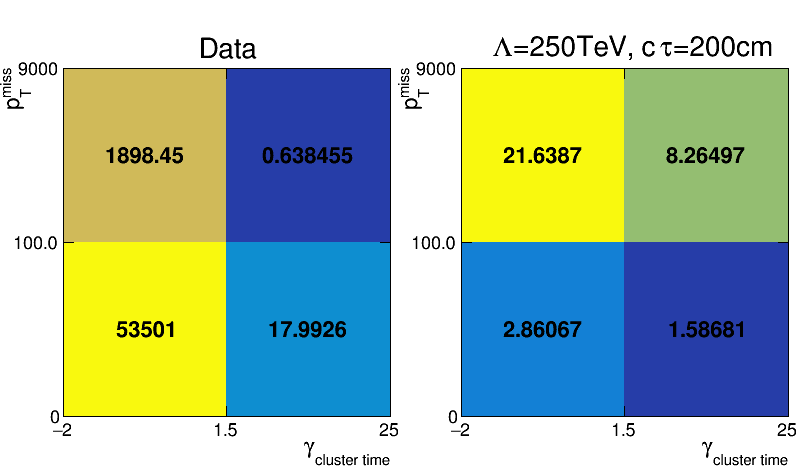

In [9]:
# Cut-based ID ABCD inclusive trigger
DNN_threshold = -1

N_BA, N_DA = getTransferFactor(DNN_threshold, cut_based_id_inclusive)
binA, binB_pred, binC_pred, binD_pred = getBackgroundPrediction(DNN_threshold, N_BA, N_DA, cut_based_id_inclusive)

signal_yield = getSignalYield(DNN_threshold, cut_based_id_inclusive)


hist_data = rt.TH2F("hist_data", ";#gamma_{cluster time};p_{T}^{miss}", 2, -2, 25, 2, 0, 9000)
hist_data.SetBinContent(1, 1, binA)
hist_data.SetBinContent(1, 2, binB_pred)
hist_data.SetBinContent(2, 2, binC_pred)
hist_data.SetBinContent(2, 1, binD_pred)
hist_data.SetDirectory(0)

hist_signal = rt.TH2F("hist_signal", ";#gamma_{cluster time};p_{T}^{miss}", 2, -2, 25, 2, 0, 9000)
hist_signal.SetBinContent(1, 1, signal_yield.GetBinContent(1, 1))
hist_signal.SetBinContent(1, 2, signal_yield.GetBinContent(1, 2))
hist_signal.SetBinContent(2, 2, signal_yield.GetBinContent(2, 2))
hist_signal.SetBinContent(2, 1, signal_yield.GetBinContent(2, 1))
hist_signal.SetDirectory(0)

relabel(hist_data)
relabel(hist_signal)

c1 = rt.TCanvas("c1","",800,500)
c1.cd()
pad1 = rt.TPad("pad1", "", 0, 0, 0.5, 0.9)
pad1.Draw()
pad1.cd()
hist_data.SetMarkerSize(3)
hist_data.Draw("COL TEXT")
pad1.SetLogz()
c1.cd()
pad2 = rt.TPad("pad2", "", 0.5, 0, 1, 0.9)
pad2.Draw()
pad2.cd()
hist_signal.SetMarkerSize(3)
hist_signal.Draw("COL TEXT")
pad2.SetLogz()

# Draw title
c1.cd()
latex = rt.TLatex()
latex.SetTextFont(42)
latex.SetTextAngle(0)
latex.SetTextColor(rt.kBlack)
latex.SetTextSize(0.065)
latex.SetTextAlign(12)
latex.DrawLatexNDC(0.25, 0.90,"Data")
this_lambda, this_ctau = extract_num(signal_name)
signal_text = "#Lambda={}TeV, c#tau={}cm".format(this_lambda, this_ctau)
latex.DrawLatexNDC(0.62, 0.90, signal_text)

c1.Draw()
print("Totals signal: {}".format(hist_signal.Integral()))

### Cross check using cut based ID

DNN_threshold = 0
signal_hist = rt.TH2F("signal_hist", "; Time; MET", 30, -2, 5, 30, 0, 1500)
data_hist = rt.TH2F("data_hist", "; Time; MET", 30, -2, 5, 30, 0, 1500)

this_lambda, this_ctau = extract_num(signal_name)
xs = getSignalXS(signal_name)
xsecOverSumweights = float(xs)/sumWeights
cut_sig = baseline_cut
cut_sig += " && pho1DNN > {}".format(DNN_threshold)

signal_tree.Draw("t1MET:pho1ClusterTime_SmearToData>>signal_hist", 
                 "({cut_sig})*(weight*pileupWeight*triggerEffSFWeight*photonEffSF* \
                 {lumi} * {xsecOverSumweights})".format(cut_sig=cut_sig,
                                                       lumi=lumi,
                                                       xsecOverSumweights=xsecOverSumweights))

data_tree.Draw("t1MET:pho1ClusterTime_SmearToData>>data_hist", 
                 "{cut_sig}".format(cut_sig=cut_sig))

c1 = rt.TCanvas("c1","",1250,600)
c1.cd()
pad1 = rt.TPad("pad1", "", 0,0,0.5,1)
pad1.Draw()
pad1.cd()

#data_hist.Draw("COLZ")
rt.gPad.SetLogz()
c1.cd()
pad2 = rt.TPad("pad2","",0.5,0,1,1)
pad2.cd()
pad2.Draw()
signal_hist.Draw("COLZ")
rt.gPad.SetLogz()
c1.Draw()

### Signal with DNN

event_cut = 'n_Jets > 2 && n_Photons == 2 && \
             HLTDecision[81] == 1'

MET_cut = " && Flag_HBHENoiseFilter == 1 \
            &&Flag_HBHEIsoNoiseFilter ==1 \
            && Flag_goodVertices == 1 \
            && Flag_eeBadScFilter == 1 \
            && Flag_EcalDeadCellTriggerPrimitiveFilter == 1 \
            && Flag_CSCTightHaloFilter == 1  \
            && Flag_badMuonFilter == 1 \
            && Flag_badGlobalMuonFilter == 0 \
            && Flag_duplicateMuonFilter ==0"

pho_cut = '&& pho1Pt > 70 && abs(pho1Eta)<1.4442 \
            && pho1passEleVeto \
            && abs(pho1HoverE) < 0.08 \
            && pho1R9 > 0.85 && abs(pho1SigmaIetaIeta) < 0.024'
# && abs(pho1ecalPFClusterIso) < 7.5 \
#             && abs(pho1hcalPFClusterIso) < 5.0 \
#             && abs(pho1trkSumPtHollowConeDR03) < 7.5 



pho_cutbasedID = '&& pho1Pt > 70 \
                && pho1R9 > 0.9 \
                && abs(pho1Eta)<1.4442 \
                && pho1passEleVeto \
                && pho1Sminor<0.4 \
                && pho1passSigmaIetaIetaTight \
                && pho1passHoverETight \
                && pho1passSmajorTight \
                && pho1passIsoTight_comboIso'

pho2_cut = '&& pho2SigmaIetaIeta < 0.03 \
            && pho2HoverE < 0.1 \
            && pho2ecalPFClusterIso < 30.0 \
            && pho2sumNeutralHadronEt < 30.0 \
            && pho2trkSumPtHollowConeDR03 < 30.0'

baseline_cut = event_cut + pho_cut + MET_cut + pho2_cut
cut_based_id = event_cut + pho_cutbasedID + MET_cut + pho2_cut


DNN_threshold = 0.
signal_hist = rt.TH2F("signal_hist", "; #gamma_{cluster time}; p_{T}^{miss}", 30, -2, 5, 30, 0, 1500)

this_lambda, this_ctau = extract_num(signal_name)
xs = getSignalXS(signal_name)
xsecOverSumweights = float(xs)/sumWeights
cut_sig = baseline_cut
#cut_sig += " && pho1DNN > {}".format(DNN_threshold)

signal_tree.Draw("t1MET:pho1ClusterTime_SmearToData>>signal_hist", 
                 "({cut_sig})*(weight*pileupWeight*triggerEffSFWeight*photonEffSF* \
                 {lumi} * {xsecOverSumweights})".format(cut_sig=cut_sig,
                                                       lumi=lumi,
                                                       xsecOverSumweights=xsecOverSumweights))

c1 = rt.TCanvas("c1","",750,600)
c1.SetRightMargin(0.2)
c1.cd()
signal_hist.Draw("COLZ")
rt.gPad.SetLogz()
c1.Draw()

print(signal_hist.Integral())

### Signal with cut based ID

signal_hist = rt.TH2F("signal_hist", "; Time; MET", 30, -2, 5, 30, 0, 1500)

this_lambda, this_ctau = extract_num(signal_name)
xs = getSignalXS(signal_name)
xsecOverSumweights = float(xs)/sumWeights
cut_sig = cut_based_id

signal_tree.Draw("t1MET:pho1ClusterTime_SmearToData>>signal_hist", 
                 "({cut_sig})*(weight*pileupWeight*triggerEffSFWeight*photonEffSF* \
                 {lumi} * {xsecOverSumweights})".format(cut_sig=cut_sig,
                                                       lumi=lumi,
                                                       xsecOverSumweights=xsecOverSumweights))

c1 = rt.TCanvas("c1","",750,600)
c1.SetRightMargin(0.2)
c1.cd()
signal_hist.Draw("COLZ")
rt.gPad.SetLogz()
c1.Draw()



### Time template


signal_score = rt.TH1F("signal_score", ";Events;pho1DNN", 30, 0, 1)

this_lambda, this_ctau = extract_num(signal_name)
xs = getSignalXS(signal_name)
xsecOverSumweights = float(xs)/sumWeights
cut_sig = baseline_cut
cut_sig += " && pho1DNN > {}".format(DNN_threshold)

signal_tree.Draw("pho1DNN>>signal_score", 
                 "({cut_sig})*(weight*pileupWeight*triggerEffSFWeight*photonEffSF* \
                  {lumi} * {xsecOverSumweights})".format(cut_sig=cut_sig,
                                                       lumi=lumi,
                                                       xsecOverSumweights=xsecOverSumweights))

signal_score.SetFillColor(rt.kAzure+8)
signal_score.SetLineColor(rt.kAzure+9)
signal_score.SetLineWidth(2)
signal_score.GetYaxis().SetTitleOffset(1.)
signal_score.SetDirectory(0)

c2 = rt.TCanvas("c2", "", 50, 50, W, H)
c2.cd()
c2.SetLeftMargin(L/W)
c2.SetRightMargin(R/W)
c2.SetTopMargin(T/W)
c2.SetBottomMargin(B/W)

signal_score.Draw("hist")
rt.gPad.SetLogy()
c2.Draw()
CMS_lumi.CMS_lumi(c2, iPeriod, iPos)
c2.cd()
line2 = rt.TLine(time_boundary, 0, time_boundary, 6e4)
line2.SetLineStyle(7)
line2.SetLineWidth(3)
line2.Draw()


latex = rt.TLatex()
latex.SetTextFont(42)
latex.SetTextAngle(0)
latex.SetTextColor(rt.kBlack)
latex.SetTextSize(0.045)
latex.SetTextAlign(12)
latex.DrawLatexNDC(0.2, 0.8,"#Lambda = %d TeV, c#tau = %d"%(this_lambda, this_ctau))


### QCD score



### Time template


signal_score = rt.TH1F("signal_score", ";Events;pho1DNN", 30, 0, 1)

this_lambda, this_ctau = extract_num(signal_name)
xs = getSignalXS(signal_name)
xsecOverSumweights = float(xs)/sumWeights
cut_sig = baseline_cut
cut_sig += " && pho1DNN > {}".format(DNN_threshold)

signal_tree.Draw("pho1DNN>>signal_score", 
                 "({cut_sig})*(weight*pileupWeight*triggerEffSFWeight*photonEffSF* \
                  {lumi} * {xsecOverSumweights})".format(cut_sig=cut_sig,
                                                       lumi=lumi,
                                                       xsecOverSumweights=xsecOverSumweights))

signal_score.SetFillColor(rt.kAzure+8)
signal_score.SetLineColor(rt.kAzure+9)
signal_score.SetLineWidth(2)
signal_score.GetYaxis().SetTitleOffset(1.)
signal_score.SetDirectory(0)

c2 = rt.TCanvas("c2", "", 50, 50, W, H)
c2.cd()
c2.SetLeftMargin(L/W)
c2.SetRightMargin(R/W)
c2.SetTopMargin(T/W)
c2.SetBottomMargin(B/W)

signal_score.Draw("hist")
rt.gPad.SetLogy()
c2.Draw()
CMS_lumi.CMS_lumi(c2, iPeriod, iPos)
c2.cd()
line2 = rt.TLine(time_boundary, 0, time_boundary, 6e4)
line2.SetLineStyle(7)
line2.SetLineWidth(3)
line2.Draw()


latex = rt.TLatex()
latex.SetTextFont(42)
latex.SetTextAngle(0)
latex.SetTextColor(rt.kBlack)
latex.SetTextSize(0.045)
latex.SetTextAlign(12)
latex.DrawLatexNDC(0.2, 0.8,"#Lambda = %d TeV, c#tau = %d"%(this_lambda, this_ctau))


### Optimizing threshold

DNN_thresholds = np.linspace(0, 1, 10)
overall_significance = []
significance_B = []
significance_C = []
significance_D = []

for thres in DNN_thresholds:
    sig = getSignificance(thres, baseline_cut)
    overall_significance.append(sig[0])
    significance_B.append(sig[1])
    significance_C.append(sig[2])
    significance_D.append(sig[3])

plt.figure(figsize=(7,7))
plt.plot(DNN_thresholds, overall_significance, label='Bin B+C+D')
plt.plot(DNN_thresholds, significance_B, label='Bin B')
plt.plot(DNN_thresholds, significance_C, label='Bin C')
plt.plot(DNN_thresholds, significance_D, label='Bin D')
plt.xlabel('$\gamma_1$ DNN score', fontsize=15)
plt.ylabel('Significance', fontsize=15)
plt.hlines(sig_cutbased[0], 0, 1, linestyle='--', label='Cut based ID')
best_sig_idx = np.argmax(overall_significance)
plt.legend(loc='best', frameon=0, fontsize=15)
title = r"$\Lambda$=%dTeV, c$\tau$=%dcm"%(this_lambda, this_ctau)
plt.title(title, fontsize=15)
print("best significance = {:.2f} at DNN threshold {:.2f}".format(overall_significance[best_sig_idx],
                                                                 DNN_thresholds[best_sig_idx]))

significance(s=0.075, b=9.9)

significance(s=0.29, b=13.12)

In [21]:
trigger_to_scan = [80, 81, 82, 84, 85, 86, 87, 101, 102, 103, 104, 112, 116, 220, 221, 245, 246]

no_trigger_baseline_cut = event_cut + pho_cutbasedID + MET_cut + pho2_cut
signal_hist = {}
trigger_evtCount = {}

this_lambda, this_ctau = extract_num(signal_name)
xs = getSignalXS(signal_name)
xsecOverSumweights = float(xs)/sumWeights

for trigger in trigger_to_scan:
    trigger_cut = '&& (HLTDecision[81] == 1 || HLTDecision[{}] == 1)'.format(trigger)
    this_cut = no_trigger_baseline_cut + trigger_cut 
    this_selection = "({this_cut}) * weight * \
                        pileupWeight * \
                        triggerEffSFWeight * \
                        photonEffSF * {lumi} \
                        * {xsecOverSumweights}".format(this_cut=this_cut,
                                                      lumi=lumi,
                                                      xsecOverSumweights=xsecOverSumweights)
    signal_hist[trigger] = rt.TH1F("signal_hist{}".format(trigger), "; #gamma_{cluster time} (ns)", 80, -2, 25)
    signal_tree.Draw("pho1ClusterTime_SmearToData >> signal_hist{}".format(trigger), this_selection)
    trigger_evtCount[trigger] = signal_hist[trigger].Integral()
    
print(trigger_evtCount)

{80: 28.927149258553982, 81: 28.814757637679577, 82: 30.272211246192455, 84: 28.814757637679577, 85: 30.076220951974392, 86: 30.13645764440298, 87: 29.503425143659115, 101: 33.27020028978586, 102: 33.59054846316576, 103: 31.46679725497961, 104: 30.445465050637722, 112: 33.29228741675615, 116: 33.580149706453085, 220: 29.14488484710455, 221: 28.96341111510992, 245: 34.67657943442464, 246: 34.419246423989534}


In [22]:
for trigger in trigger_evtCount:
    base_num = trigger_evtCount[81]
    print(trigger, "{:.2f}".format(trigger_evtCount[trigger]), "+{:.2f}%".format((trigger_evtCount[trigger]/base_num-1)*100))

80 28.93 +0.39%
81 28.81 +0.00%
82 30.27 +5.06%
84 28.81 +0.00%
85 30.08 +4.38%
86 30.14 +4.59%
87 29.50 +2.39%
101 33.27 +15.46%
102 33.59 +16.57%
103 31.47 +9.20%
104 30.45 +5.66%
112 33.29 +15.54%
116 33.58 +16.54%
220 29.14 +1.15%
221 28.96 +0.52%
245 34.68 +20.34%
246 34.42 +19.45%


In [37]:
no_trigger_baseline_cut = event_cut + pho_cutbasedID + MET_cut + pho2_cut
trigger_cut = '&& (HLTDecision[81] == 1 \
                 || HLTDecision[245] == 1 \
                 || HLTDecision[102] == 1)'
this_cut = no_trigger_baseline_cut + trigger_cut 
this_selection = "({this_cut}) * weight * \
                        pileupWeight * \
                        triggerEffSFWeight * \
                        photonEffSF * {lumi} \
                        * {xsecOverSumweights}".format(this_cut=this_cut,
                                                      lumi=lumi,
                                                      xsecOverSumweights=xsecOverSumweights)
signal_hist = rt.TH1F("signal_hist".format(trigger), "; #gamma_{cluster time} (ns)", 80, -2, 25)
signal_tree.Draw("pho1ClusterTime_SmearToData >> signal_hist".format(trigger), this_selection)
print(signal_hist.Integral())
print(signal_hist.Integral()/trigger_evtCount[81] - 1)

34.78153784945607
0.20707376014761425


Warning in <TFile::Append>: Replacing existing TH1: signal_hist (Potential memory leak).


In [36]:
no_trigger_baseline_cut = event_cut + pho_cutbasedID + MET_cut + pho2_cut
trigger_cut = '&& (HLTDecision[81] == 1 || HLTDecision[102] == 1)'
this_cut = no_trigger_baseline_cut + trigger_cut 
this_selection = "({this_cut}) * weight * \
                        pileupWeight * \
                        triggerEffSFWeight * \
                        photonEffSF * {lumi} \
                        * {xsecOverSumweights}".format(this_cut=this_cut,
                                                      lumi=lumi,
                                                      xsecOverSumweights=xsecOverSumweights)
signal_hist = rt.TH1F("signal_hist".format(trigger), "; #gamma_{cluster time} (ns)", 80, -2, 25)
signal_tree.Draw("pho1ClusterTime_SmearToData >> signal_hist".format(trigger), this_selection)
print(signal_hist.Integral())
print(signal_hist.Integral()/trigger_evtCount[81] - 1)

33.59054846316576
0.16574114158923647


Warning in <TFile::Append>: Replacing existing TH1: signal_hist (Potential memory leak).


In [39]:
no_trigger_baseline_cut = event_cut + pho_cutbasedID + MET_cut + pho2_cut
trigger_cut = '&& (HLTDecision[81] == 1 || HLTDecision[245] == 1 )'
this_cut = no_trigger_baseline_cut + trigger_cut 
this_selection = "({this_cut}) * weight * \
                        pileupWeight * \
                        triggerEffSFWeight * \
                        photonEffSF * {lumi} \
                        * {xsecOverSumweights}".format(this_cut=this_cut,
                                                      lumi=lumi,
                                                      xsecOverSumweights=xsecOverSumweights)
signal_hist = rt.TH1F("signal_hist".format(trigger), "; #gamma_{cluster time} (ns)", 80, -2, 25)
signal_tree.Draw("pho1ClusterTime_SmearToData >> signal_hist".format(trigger), this_selection)
print(signal_hist.Integral())
print(signal_hist.Integral()/trigger_evtCount[81] - 1)

34.67657943442464
0.20343123723101741


Warning in <TFile::Append>: Replacing existing TH1: signal_hist (Potential memory leak).


In [51]:
no_trigger_baseline_cut = event_cut + pho_cutbasedID + MET_cut + pho2_cut
trigger_cut = '&& (HLTDecision[245] == 1 && HLTDecision[102] == 0)'
this_cut = no_trigger_baseline_cut + trigger_cut 
this_selection = "({this_cut}) * weight * \
                        pileupWeight * \
                        triggerEffSFWeight * \
                        photonEffSF * {lumi} \
                        * {xsecOverSumweights}".format(this_cut=this_cut,
                                                      lumi=lumi,
                                                      xsecOverSumweights=xsecOverSumweights)
signal_hist = rt.TH1F("signal_hist".format(trigger), "; #gamma_{cluster time} (ns)", 80, -2, 25)
signal_tree.Draw("pho1ClusterTime_SmearToData >> signal_hist".format(trigger), this_selection)
print(signal_hist.Integral())
print(signal_hist.Integral()/trigger_evtCount[81] - 1)

5.184697151184082
-0.8200679937559384


Warning in <TFile::Append>: Replacing existing TH1: signal_hist (Potential memory leak).
